# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from HANCModel import HANCModelClass

C:\Users\hms467\AppData\Local\Temp\ipykernel_3852\535149305.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
#outfolder = r'C:\Users\hms467\OneDrive - University of Copenhagen\Documents\Uni\11. semester\AMHA\AdvMacroHet\Assignments\Handin\Exam\output'
outfolder = r'C:\Users\hms467\Dropbox\Apps\Overleaf\AMHA_exam\input'


# Setup

In [3]:
model = HANCModelClass(name='baseline')

In [4]:
par = model.par
ss = model.ss
path = model.path

# Find stationary equilibrium

In [5]:
model.find_ss(do_print=True)

### step 1: broad search ###

implied ss.r = -0.0900
implied ss.w = 3.0071
household problem in ss solved in 2.7 secs [119 iterations]
household problem in ss simulated in 4.2 secs [99 iterations]
implied ss.C_hh = 2.8820
implied ss.A_hh = 1.3902
clearing_A = -127.48618180

implied ss.r = -0.0250
implied ss.w = 1.2680
household problem in ss solved in 0.1 secs [203 iterations]
household problem in ss simulated in 0.0 secs [183 iterations]
implied ss.C_hh = 1.2570
implied ss.A_hh = 0.4397
clearing_A =  -6.80605995

implied ss.r = 0.0400
implied ss.w = 0.9704
household problem in ss solved in 0.3 secs [730 iterations]
household problem in ss simulated in 1.1 secs [7048 iterations]
implied ss.C_hh = 2.7462
implied ss.A_hh = 49.6238
clearing_A =  46.65317062

### step 2: determine search bracket ###

rK in [  0.07500000,  0.14000000]

### step 3: search ###

done

implied ss.r = 0.0198
implied ss.w = 1.0373
household problem in ss solved in 0.3 secs [634 iterations]
household problem in ss

In [52]:
ss.alpha

0.3

# a)

In [6]:
def solve_model_across_par(model,parname, values ):
    model_list = []

    for value in values:
        model_i = model.copy()
        setattr(model_i.par,parname, value)
        model_i.find_ss(do_print=False)

        model_list.extend([model_i])

    return model_list
        

In [7]:
m_list = solve_model_across_par(model,'sigma_psi',[0.1,0.12,0.14])

In [8]:
def gini(x, w=None):
    # Taken from https://stackoverflow.com/questions/48999542/more-efficient-weighted-gini-coefficient-in-python
    # The rest of the code requires numpy arrays.
    x = np.asarray(x)
    if w is not None:
        w = np.asarray(w)
        sorted_indices = np.argsort(x)
        sorted_x = x[sorted_indices]
        sorted_w = w[sorted_indices]
        # Force float dtype to avoid overflows
        cumw = np.cumsum(sorted_w, dtype=float)
        cumxw = np.cumsum(sorted_x * sorted_w, dtype=float)
        return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) / 
                (cumxw[-1] * cumw[-1]))
    else:
        sorted_x = np.sort(x)
        n = len(x)
        cumx = np.cumsum(sorted_x, dtype=float)
        # The above formula, with all weights equal to 1 simplifies to:
        return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

In [49]:
# Functions that make a latex table of statistics over a parameter space

def make_row_ss(model):
    ss = model.ss
    par = model.par
    
    
    Ds =np.sum(ss.D,axis=(0,2))
    # Gini of wage 
    gini_ws = gini(ss.w*par.s_grid,w=Ds)

    # Gini of capital income 
    ##  Individual returns 
    
    r_i =(ss.rK *( 1 +  par.chi_grid* par.sigma_chi  - (1-par.chi_grid)* par.sigma_chi* par.pi_chi_obar/par.pi_chi_ubar ) ) -par.delta
    rA_i = (par.a_grid*r_i[:,np.newaxis]).ravel()

    Ds_rav = np.sum(ss.D,axis=(0)).ravel()

    gini_rA = gini(rA_i,Ds_rav)

    # Gini of savings
    
    Da = np.sum(ss.D,axis=(0,1))
    Da_cs = np.cumsum(Da)
    
    gini_a = gini(par.a_grid,w=Da)


    # Skeewness of savings
    skeew_a = np.sum(Da * ((par.a_grid-ss.A_hh)/ss.std_A)**3  )

    return [ss.w, ss.std_ws, gini_ws,ss.K,ss.std_A,skeew_a,gini_a, ss.rA_hh,ss.std_rA,gini_rA]


def make_multiindex(outvars,stats_list,parname):
    column_format = 'l'
    tuples = []
    for outvar, stats in zip(outvars,stats_list):
        tuples.extend([(outvar,stat) for stat in stats])
        column_format += '|'+ len(stats)*'c'

    mi = pd.MultiIndex.from_tuples(tuples, names=['',parname])

    return mi, column_format

def make_table(m_list,parname, values,tabname,
                make_row = make_row_ss, 
                outvars = ['$w_{ss}s_{i,ss}$','$a_{i,ss}$',r'$\left(r^{k}_{i,ss}-\delta\right)a_{i,ss}$'],
                stats_list = [['$\mathbb{E}$','$Std$','Gini'],['$\mathbb{E}$','$Std$','Skewness','Gini'],['$\mathbb{E}$','$Std$','Gini'] ]
                ):
    df_tab = pd.DataFrame.from_dict(data= {f'{value}': make_row(model) for value, model in zip(values,m_list) },
                                    orient='index' )


    mi, column_format = make_multiindex(outvars,stats_list,parname)
    #df_tab.index.name = parname
    df_tab.columns = mi
    
    
    df_style = df_tab.style.format(precision= 3)
    df_style.to_latex(outfolder+f'\{tabname}.tex',hrules=True,
                        column_format=column_format,
                        multicol_align='c')

    return df_tab 

df_tab = make_table(m_list,'$\sigma_{\psi}$',[0.1,0.12,0.14],'tab_a')
df_tab

$w_{ss}s_{i,ss}$               $a_{i,ss}$                 \
$\sigma_{\psi}$     $\mathbb{E}$ $Std$  Gini $\mathbb{E}$ $Std$ Skewness   
0.1                        1.037 0.336 0.173        3.710 4.728    2.230   
0.12                       1.049 0.409 0.207        3.851 4.919    2.240   
0.14                       1.063 0.486 0.239        4.025 5.176    2.237   

                      $\left(r^{k}_{i,ss}-\delta\right)a_{i,ss}$              
$\sigma_{\psi}$  Gini                               $\mathbb{E}$ $Std$  Gini  
0.1             0.611                                      0.074 0.118 0.679  
0.12            0.612                                      0.064 0.110 0.703  
0.14            0.615                                      0.053 0.101 0.754

In [13]:
def make_hist(m_list,parname, values,figname=None,xlim=[0,60],ylim=[0,0.02]):
    '''
    For making histograms, not used in the assignment cause of the high density around zero
    '''
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(1,1,1)
    ymax= 0 

    for model, value in zip(m_list,values):
        ss = model.ss
        par = model.par

        Da = np.sum(ss.D,axis=(0,1))

        ax.hist(par.a_grid,bins =par.a_grid,weights=Da,label =f'{parname}={value:.2f}',
                    alpha=0.5,density=True)

        if np.max(Da)>ymax:
            ymax = np.max(Da)*1.1

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(loc='upper right')
    if not figname is None: fig.savefig(outfolder + f'\{figname}.png')

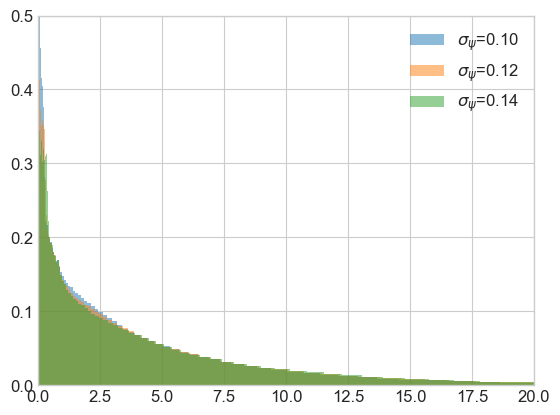

In [14]:
make_hist(m_list,'$\sigma_{\psi}$',[0.1,0.12,0.14],ylim=[0,0.5],xlim=[0,20],figname='fig_a')

In [15]:
def make_cdfs(m_list,parname, values,figname=None,
            ls_list = ['-','--','-.'],figsize=(10,6)):
    '''
    For making histograms, not used in the assignment cause of the high density around zero
    '''
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1,1,1)
    ymax= 0 

    for model, value, ls in zip(m_list,values,ls_list):
        ss = model.ss
        par = model.par

        
        label = f'{parname}={value:.2f}'
        x = np.insert(par.a_grid,0,par.a_grid[0])
        y = np.insert(np.cumsum(np.sum(ss.D,axis=(0,1))),0,0.0)
        ax.plot(x,y,label=label,ls=ls,alpha=0.9)
        ax.set_xlabel('assets, $a_{t}$')
        ax.set_ylabel('CDF')
        ax.set_xscale('symlog')


    
    ax.legend(loc='lower right')
    if not figname is None: fig.savefig(outfolder + f'\{figname}.png')

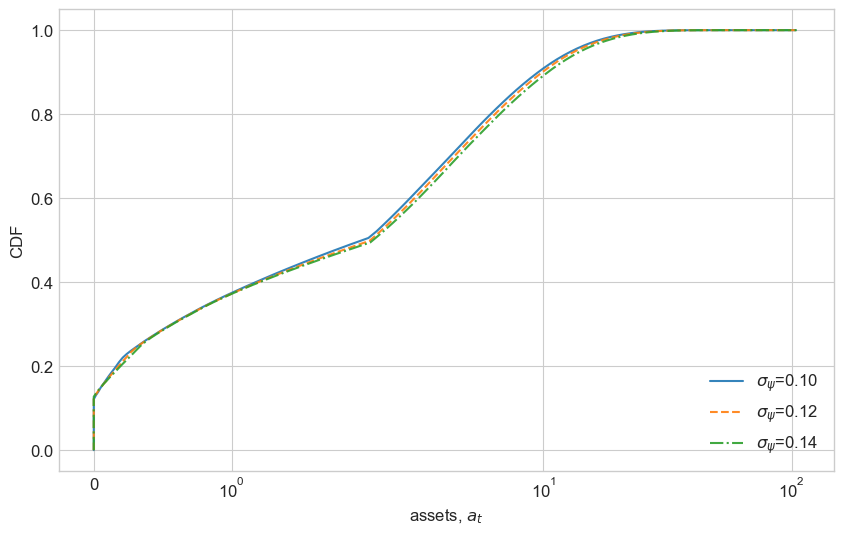

In [16]:
make_cdfs(m_list,'$\sigma_{\psi}$',[0.1,0.12,0.14])

# b)

In [17]:
m_list_beta = solve_model_across_par(model,'sigma_beta',[0.01,0.02,0.03])

In [50]:
df_tab = make_table(m_list_beta,'$\sigma_{\\beta}$',[0.01,0.02,0.03],'tab_b')

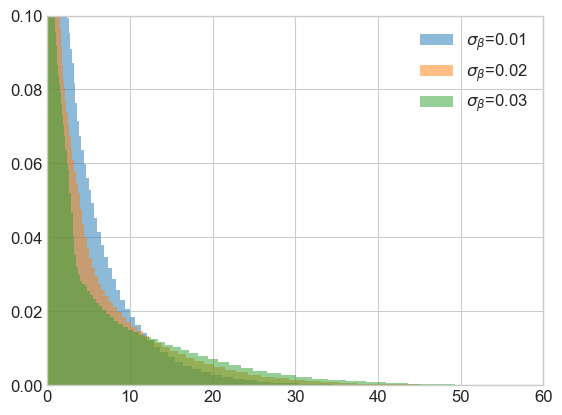

In [19]:
make_hist(m_list_beta,'$\sigma_{\\beta}$',[0.01,0.02,0.03],ylim=[0,0.1])

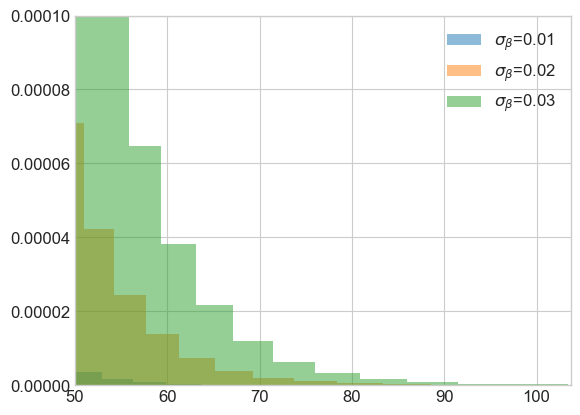

In [20]:
make_hist(m_list_beta,r'$\sigma_{\beta}$',[0.01,0.02,0.03],ylim=[0,1e-4],xlim=[50,np.max(par.a_grid)])

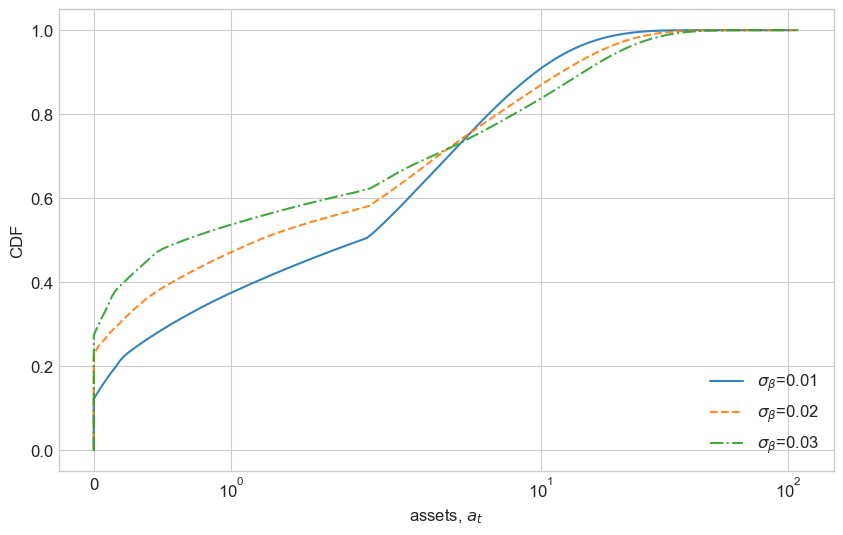

In [21]:
make_cdfs(m_list_beta,'$\sigma_{\\beta}$',[0.01,0.02,0.03],figname='fig_b_cdfs')

In [22]:
m_list_beta[2].par.beta_grid

array([0.93, 0.96, 0.99])

In [23]:
m_list_beta[1].par.beta_grid

array([0.94, 0.96, 0.98])

In [24]:
m_list_beta[0].par.beta_grid

array([0.95, 0.96, 0.97])

# c) 

In [27]:
m_list_chi = solve_model_across_par(model,'sigma_chi',[0.1,0.2,0.3])

In [51]:
df_tab = make_table(m_list_chi,'$\sigma_{\chi}$',[0.1,0.2,0.3],'tab_c')

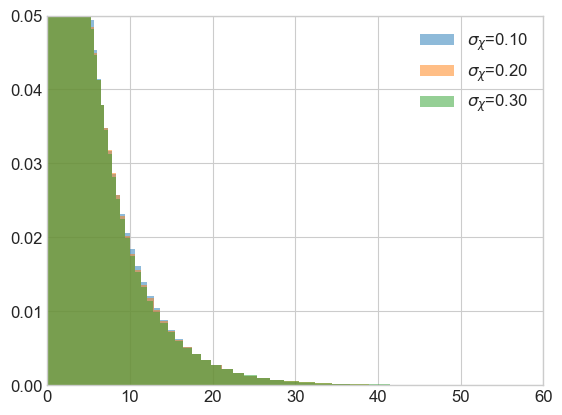

In [29]:
make_hist(m_list_chi,'$\sigma_{\chi}$',[0.1,0.2,0.3],ylim=[0,0.05])

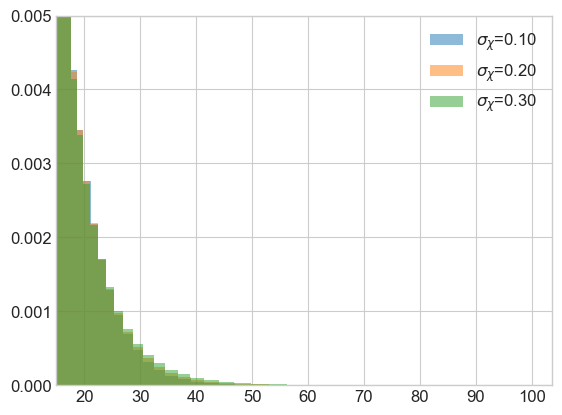

In [30]:
make_hist(m_list_chi,'$\sigma_{\chi}$',[0.1,0.2,0.3],ylim=[0,5e-3],xlim=[15,np.max(par.a_grid)])

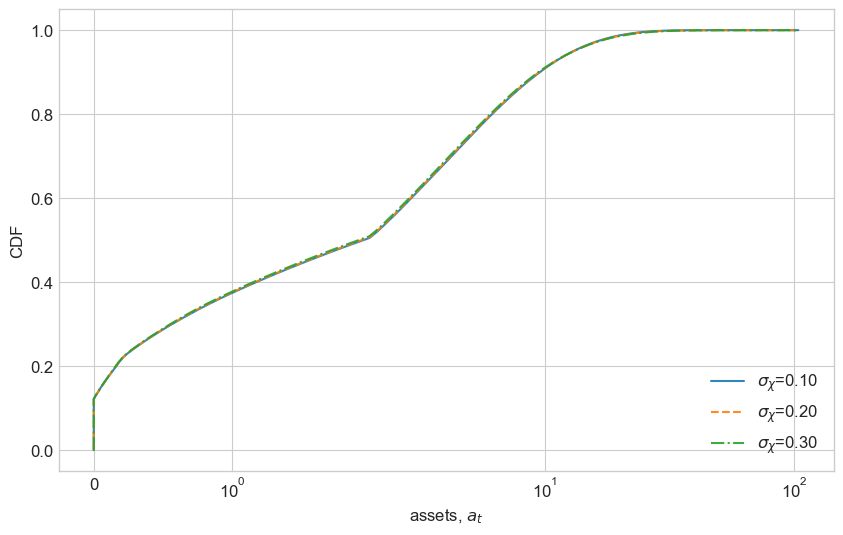

In [31]:
make_cdfs(m_list_chi,'$\sigma_{\chi}$',[0.1,0.2,0.3])

# d)

In [32]:
pass

# e) 

In [33]:
model.compute_jacs(do_print=True) 

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for rK              in 0.5 secs
curly_Y and curly_D calculated for taua            in 0.4 secs
curly_Y and curly_D calculated for thetaa          in 0.4 secs
curly_Y and curly_D calculated for w               in 0.4 secs
curly_Y and curly_D calculated for xi              in 0.5 secs
curly_E calculated in 2.3 secs
builiding blocks combined in 0.4 secs
household Jacobian computed in 4.9 secs

full Jacobians:
full Jacobian to unknowns computed in 16.3 secs [in evaluate_path(): 16.2 secs]
full Jacobian to shocks computed in 18.5 secs [in evaluate_path(): 18.3 secs]


In [34]:
model.find_transition_path(do_print=True)

finding the transition path:
 it =   0 -> max. abs. error = 1.89e-01
 it =   1 -> max. abs. error = 2.93e-03
 it =   2 -> max. abs. error = 5.20e-05
 it =   3 -> max. abs. error = 9.71e-08
 it =   4 -> max. abs. error = 5.31e-10
 it =   5 -> max. abs. error = 4.48e-13

transition path found in 4.5 secs


### shocks ###


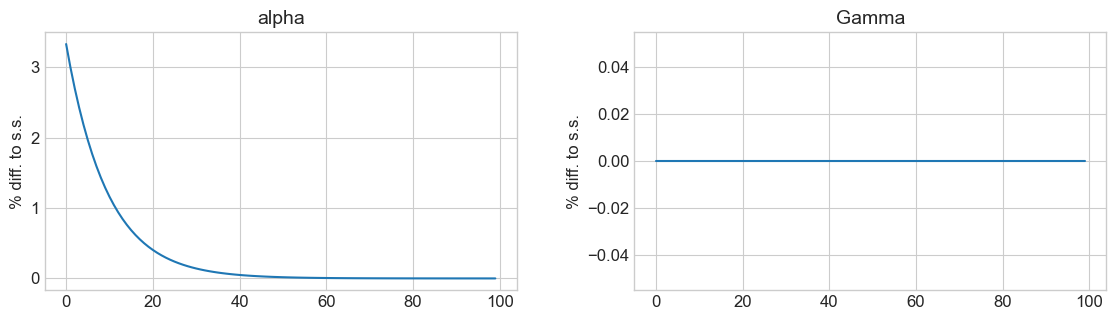


### varnames ###


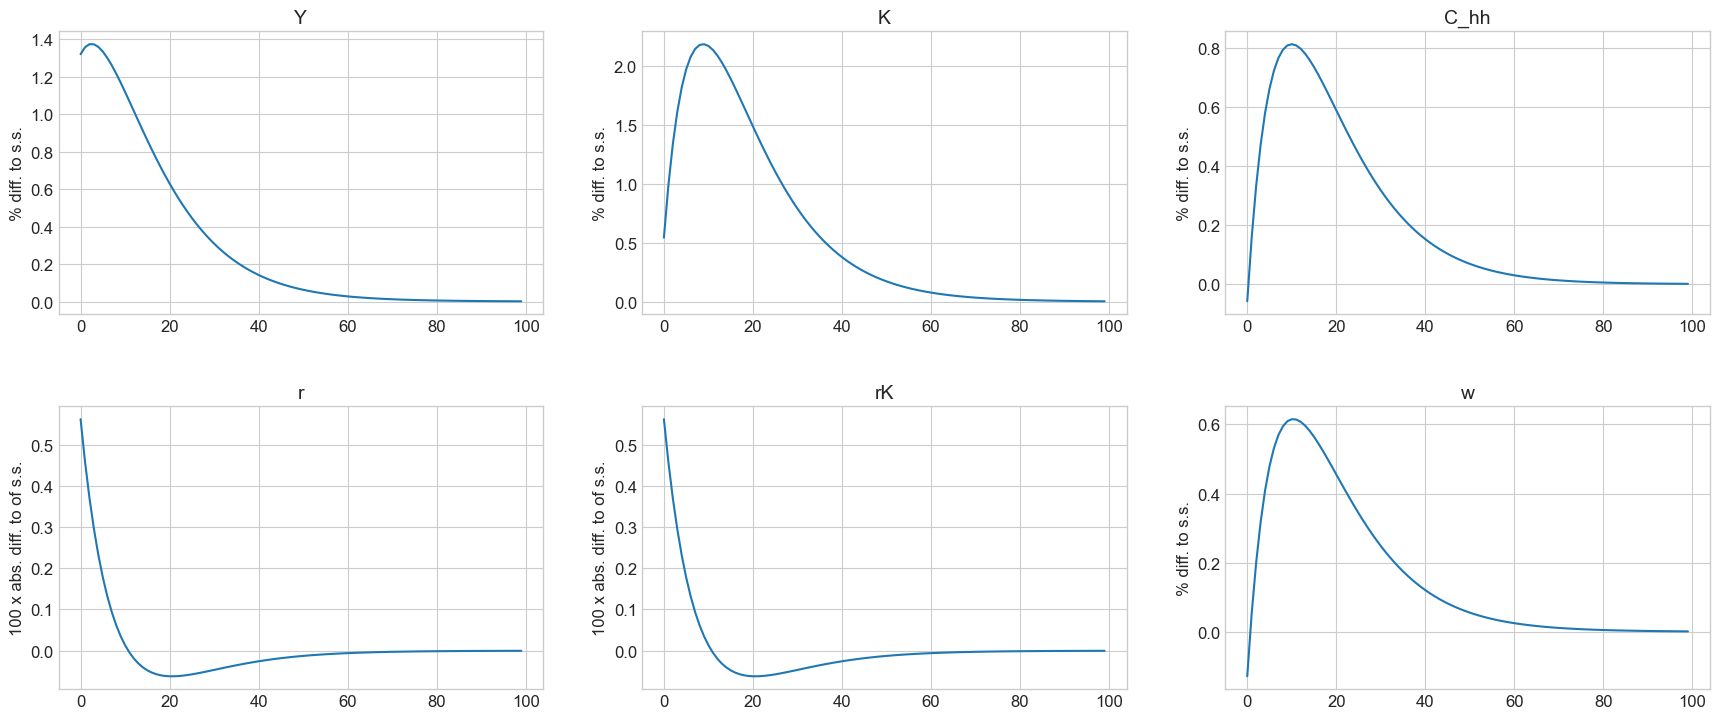


### tagets ###


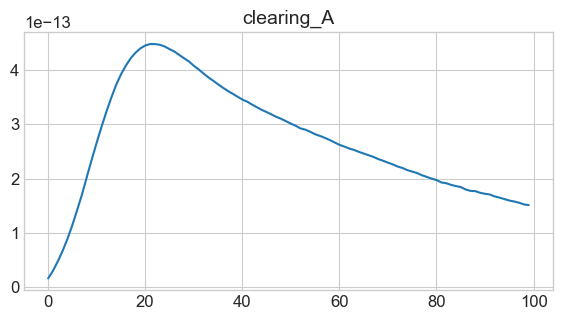

In [35]:
paths = ['Y','K','C_hh','r','rK','w']
abs_diff = ['r','rK']
facs = {'r':100,'rK':100}
model.show_IRFs(paths,abs_diff=abs_diff,facs=facs,lvl_value=['clearing_A'],ncols=3,T_max=100)

### shocks ###


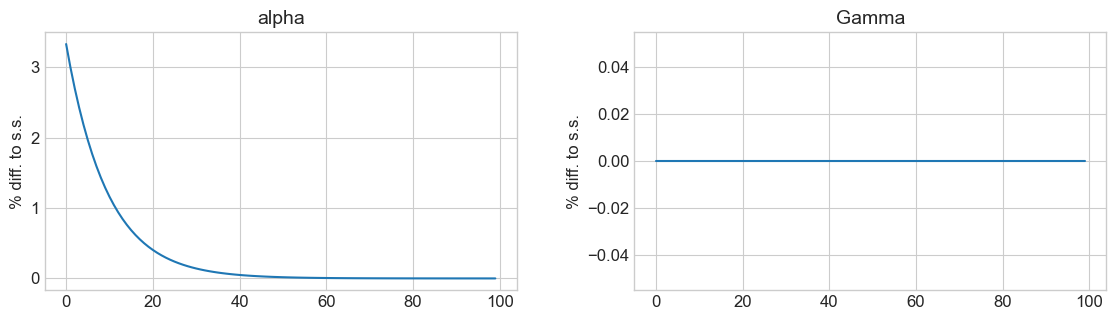


### varnames ###


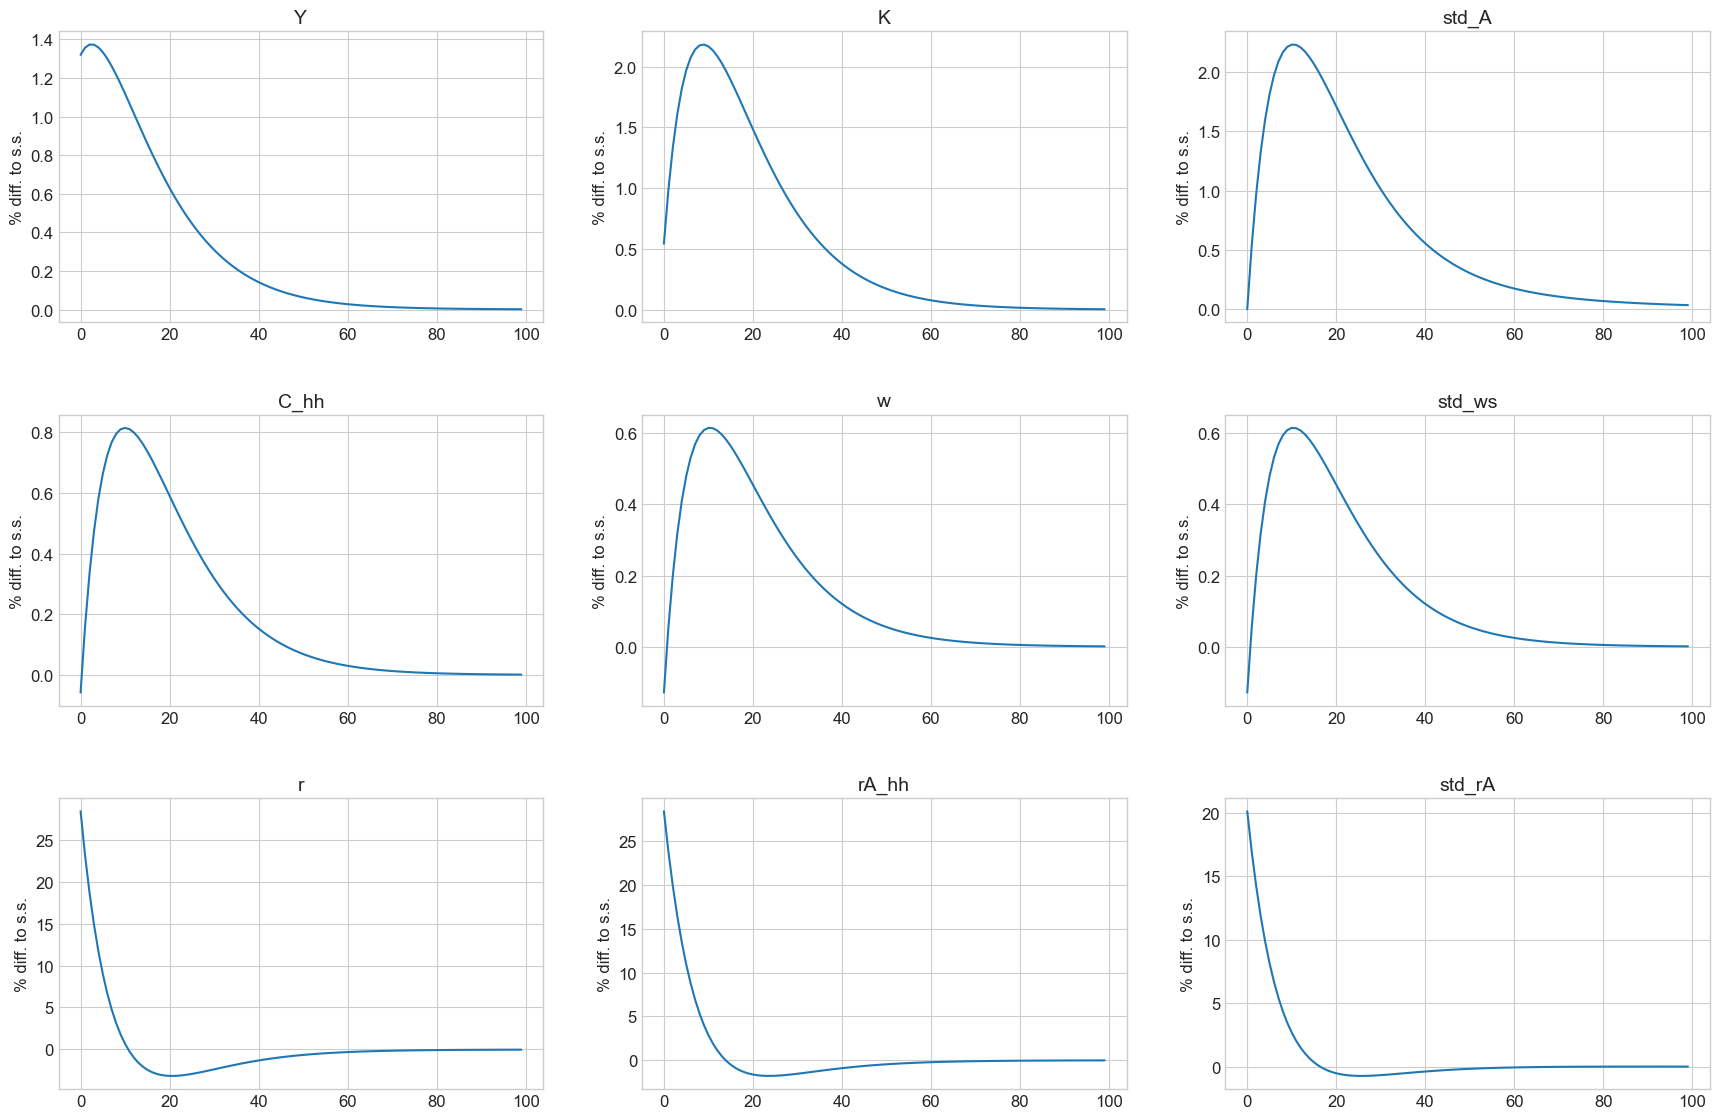

In [36]:
paths = ['Y','K','std_A','C_hh','w','std_ws','r','rA_hh','std_rA']
#abs_diff = ['r','rK']
abs_diff= []
lvl_value = ['clearing_A']
facs = {'r':100,'rK':100}
model.show_IRFs(paths,abs_diff=abs_diff,facs=facs,lvl_value=lvl_value,ncols=3,T_max=100,
                filename=outfolder+r'\IRF_e.png',do_targets=False)

# f)

In [37]:
model_f = HANCModelClass(name='tau',par= {'uptau':1.})

In [38]:
par_f = model_f.par
ss_f = model_f.ss
path_f = model_f.path

In [39]:
model_f.find_ss(do_print=True)

### step 1: broad search ###

implied ss.r = -0.0900
implied ss.w = 3.0071
household problem in ss solved in 0.1 secs [119 iterations]
household problem in ss simulated in 0.0 secs [99 iterations]
implied ss.C_hh = 2.8820
implied ss.A_hh = 1.3902
clearing_A = -127.48618180

implied ss.r = -0.0250
implied ss.w = 1.2680
household problem in ss solved in 0.1 secs [203 iterations]
household problem in ss simulated in 0.0 secs [183 iterations]
implied ss.C_hh = 1.2570
implied ss.A_hh = 0.4397
clearing_A =  -6.80605995

implied ss.r = 0.0400
implied ss.w = 0.9704
household problem in ss solved in 0.3 secs [730 iterations]
household problem in ss simulated in 1.4 secs [7048 iterations]
implied ss.C_hh = 2.7462
implied ss.A_hh = 49.6238
clearing_A =  46.65317062

### step 2: determine search bracket ###

rK in [  0.07500000,  0.14000000]

### step 3: search ###

done

implied ss.r = 0.0198
implied ss.w = 1.0373
household problem in ss solved in 0.3 secs [634 iterations]
household problem in ss

In [40]:
model_f.compute_jacs(do_print=True)

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for rK              in 2.3 secs
curly_Y and curly_D calculated for taua            in 0.3 secs
curly_Y and curly_D calculated for thetaa          in 0.4 secs
curly_Y and curly_D calculated for w               in 0.3 secs
curly_Y and curly_D calculated for xi              in 0.3 secs
curly_E calculated in 0.3 secs
builiding blocks combined in 0.4 secs
household Jacobian computed in 4.5 secs

full Jacobians:
full Jacobian to unknowns computed in 16.1 secs [in evaluate_path(): 15.9 secs]
full Jacobian to shocks computed in 19.4 secs [in evaluate_path(): 19.1 secs]


In [41]:
model_f.find_transition_path(do_print=True)

finding the transition path:
 it =   0 -> max. abs. error = 5.94e-02
 it =   1 -> max. abs. error = 4.07e-04
 it =   2 -> max. abs. error = 1.18e-06
 it =   3 -> max. abs. error = 7.40e-09
 it =   4 -> max. abs. error = 2.03e-11
 it =   5 -> max. abs. error = 5.37e-14

transition path found in 3.7 secs


### shocks ###


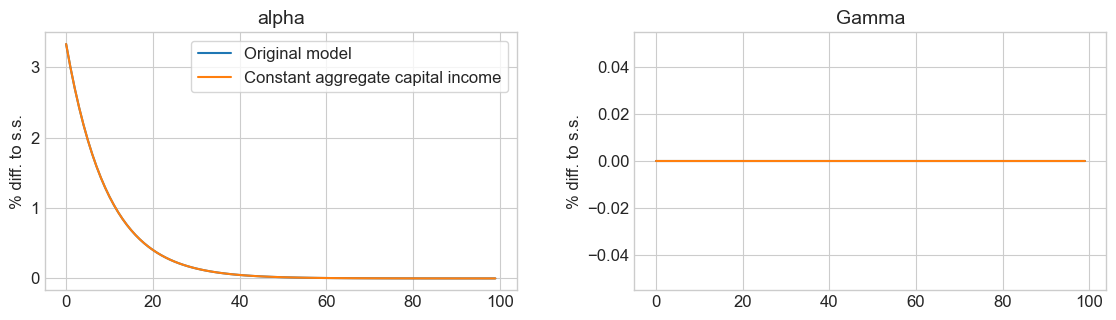


### varnames ###


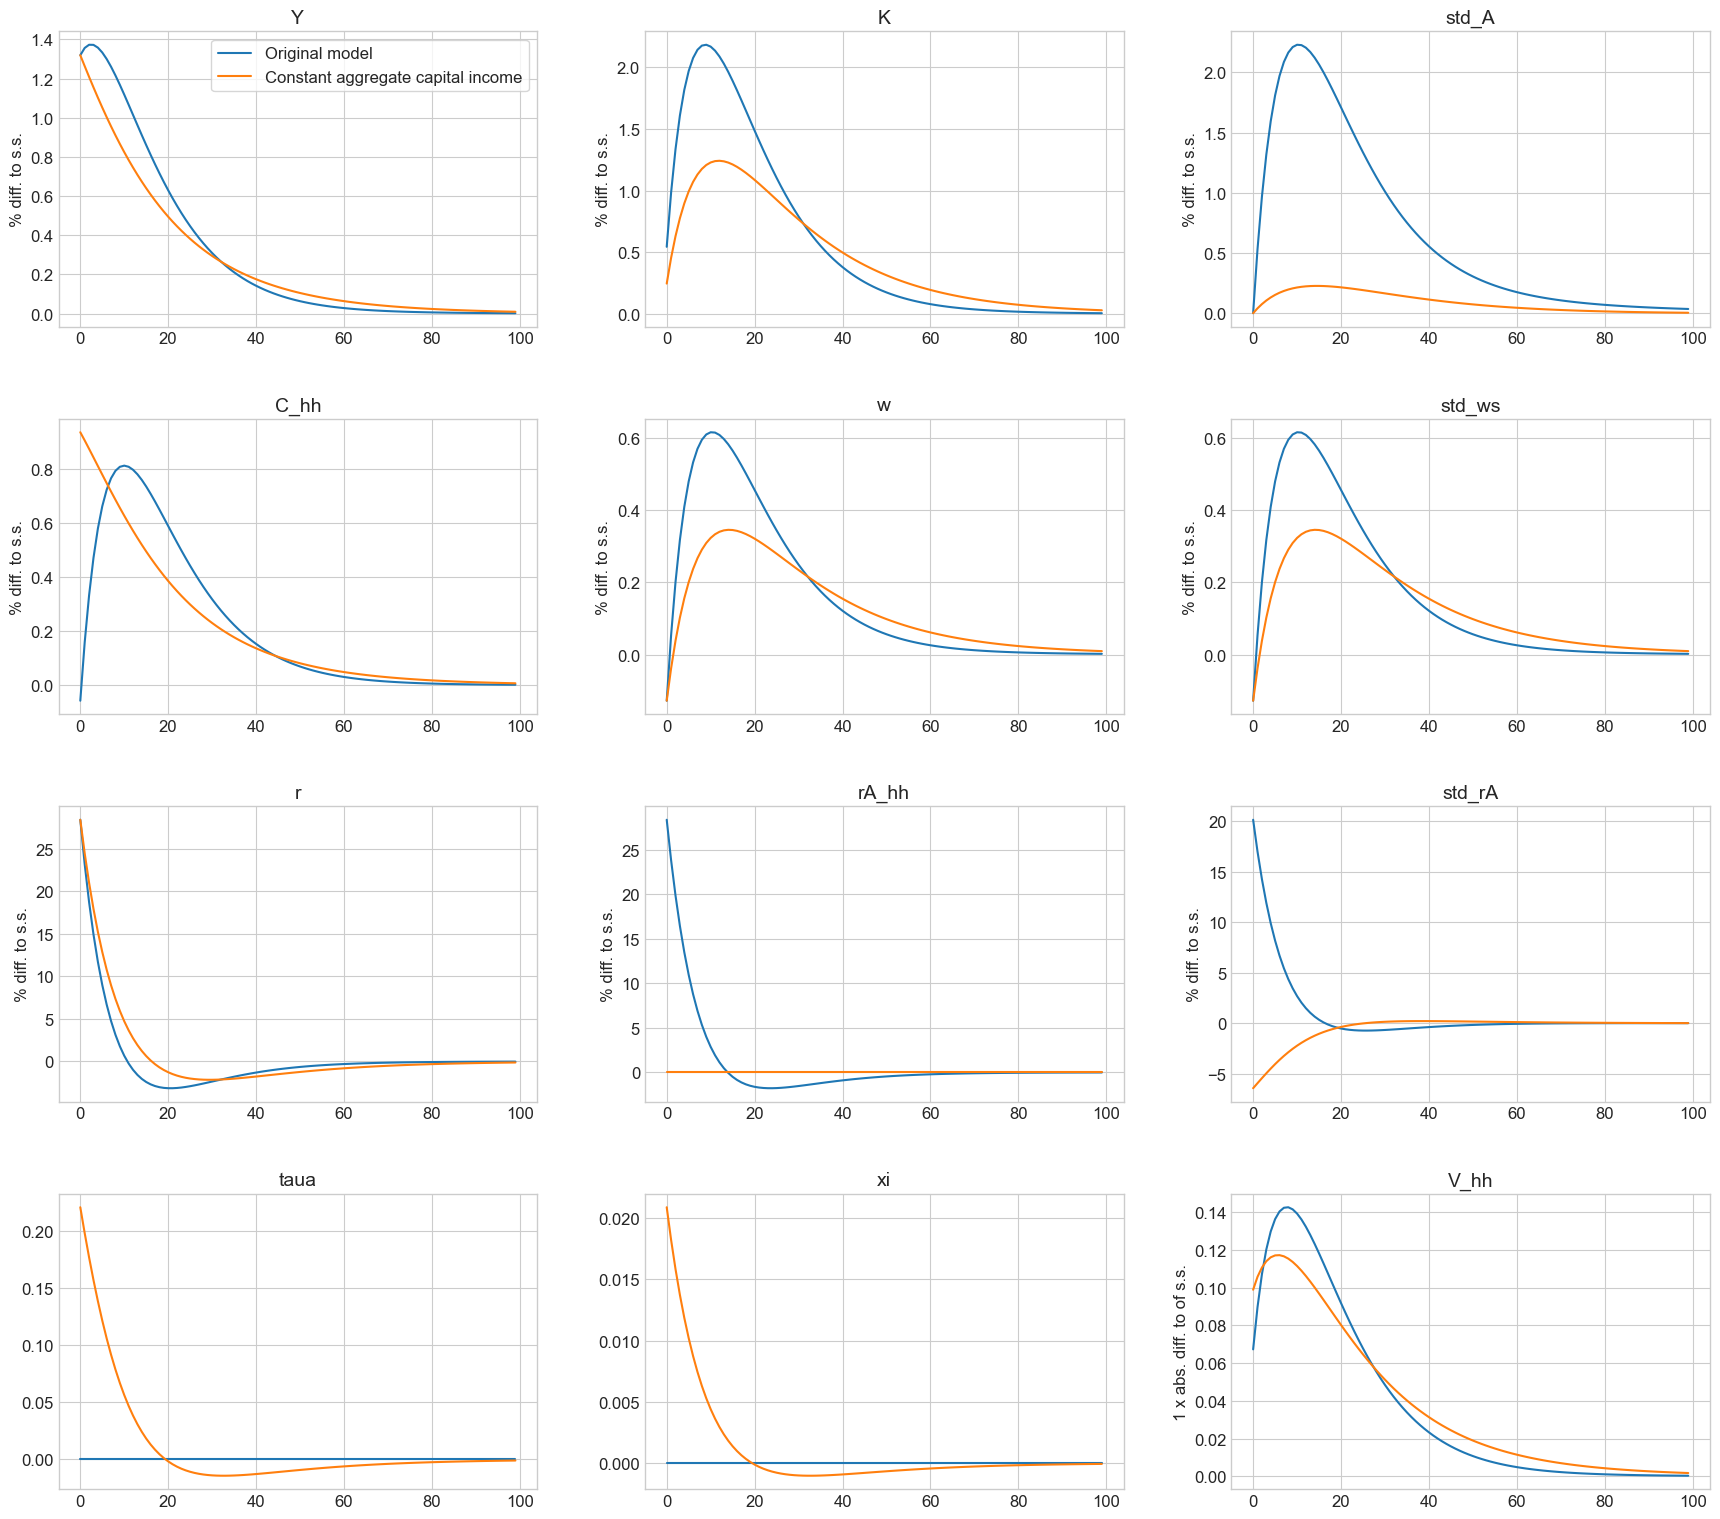


### tagets ###


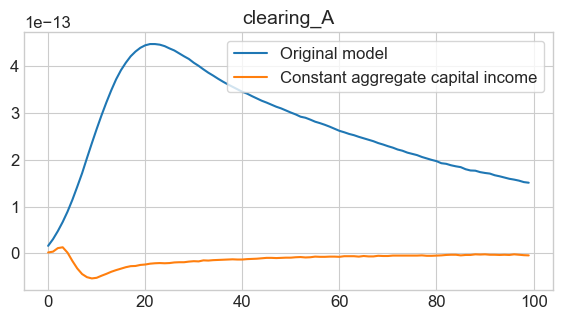

In [42]:
paths = ['Y','K','std_A','C_hh','w','std_ws','r','rA_hh','std_rA','taua','xi','V_hh']
#abs_diff = ['r','rK']
abs_diff= ['V_hh']
lvl_value = ['clearing_A','taua','xi']
facs = {'r':100,'rK':100}
model_f.compare_IRFs([model,model_f],['Original model','Constant aggregate capital income'],
                paths,abs_diff=abs_diff,facs=facs,lvl_value=lvl_value,ncols=3,T_max=100,
                )
                
# filename=outfolder+r'\IRF_f.png'

## Setting post tax interest rate constant 

In [43]:
model_theta = HANCModelClass(name='theta',par= {'vartheta':1.,'T':750})

In [44]:
model_theta.find_ss(do_print=True)

### step 1: broad search ###

implied ss.r = -0.0900
implied ss.w = 3.0071
household problem in ss solved in 0.1 secs [119 iterations]
household problem in ss simulated in 0.0 secs [99 iterations]
implied ss.C_hh = 2.8820
implied ss.A_hh = 1.3902
clearing_A = -127.48618180

implied ss.r = -0.0250
implied ss.w = 1.2680
household problem in ss solved in 0.1 secs [203 iterations]
household problem in ss simulated in 0.0 secs [183 iterations]
implied ss.C_hh = 1.2570
implied ss.A_hh = 0.4397
clearing_A =  -6.80605995

implied ss.r = 0.0400
implied ss.w = 0.9704
household problem in ss solved in 0.3 secs [730 iterations]
household problem in ss simulated in 1.6 secs [7048 iterations]
implied ss.C_hh = 2.7462
implied ss.A_hh = 49.6238
clearing_A =  46.65317062

### step 2: determine search bracket ###

rK in [  0.07500000,  0.14000000]

### step 3: search ###

done

implied ss.r = 0.0198
implied ss.w = 1.0373
household problem in ss solved in 0.2 secs [634 iterations]
household problem in ss

In [45]:
model_theta.compute_jacs(do_print=False)
model_theta.find_transition_path(do_print=True)

finding the transition path:
 it =   0 -> max. abs. error = 5.94e-02
 it =   1 -> max. abs. error = 6.43e-04
 it =   2 -> max. abs. error = 1.63e-04
 it =   3 -> max. abs. error = 1.56e-04
 it =   4 -> max. abs. error = 4.40e-04
 it =   5 -> max. abs. error = 1.51e-04
 it =   6 -> max. abs. error = 3.63e-04
 it =   7 -> max. abs. error = 1.18e-04
 it =   8 -> max. abs. error = 2.09e-04
 it =   9 -> max. abs. error = 9.45e-05
 it =  10 -> max. abs. error = 2.07e-04
 it =  11 -> max. abs. error = 5.26e-04
 it =  12 -> max. abs. error = 7.92e-04
 it =  13 -> max. abs. error = 3.32e-04
 it =  14 -> max. abs. error = 1.21e-04
 it =  15 -> max. abs. error = 7.28e-04
 it =  16 -> max. abs. error = 4.34e-05
 it =  17 -> max. abs. error = 1.68e-04
 it =  18 -> max. abs. error = 5.27e-05
 it =  19 -> max. abs. error = 7.22e-05
 it =  20 -> max. abs. error = 1.84e-04
 it =  21 -> max. abs. error = 1.12e-04
 it =  22 -> max. abs. error = 2.73e-04
 it =  23 -> max. abs. error = 1.82e-04
 it =  24 -

### shocks ###


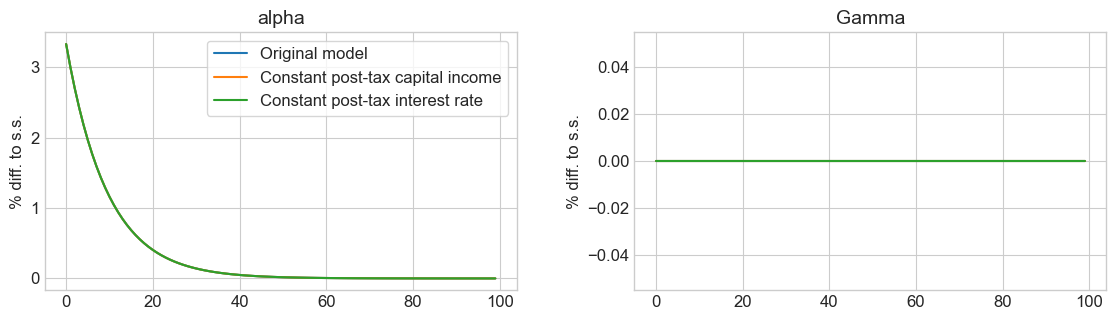


### varnames ###


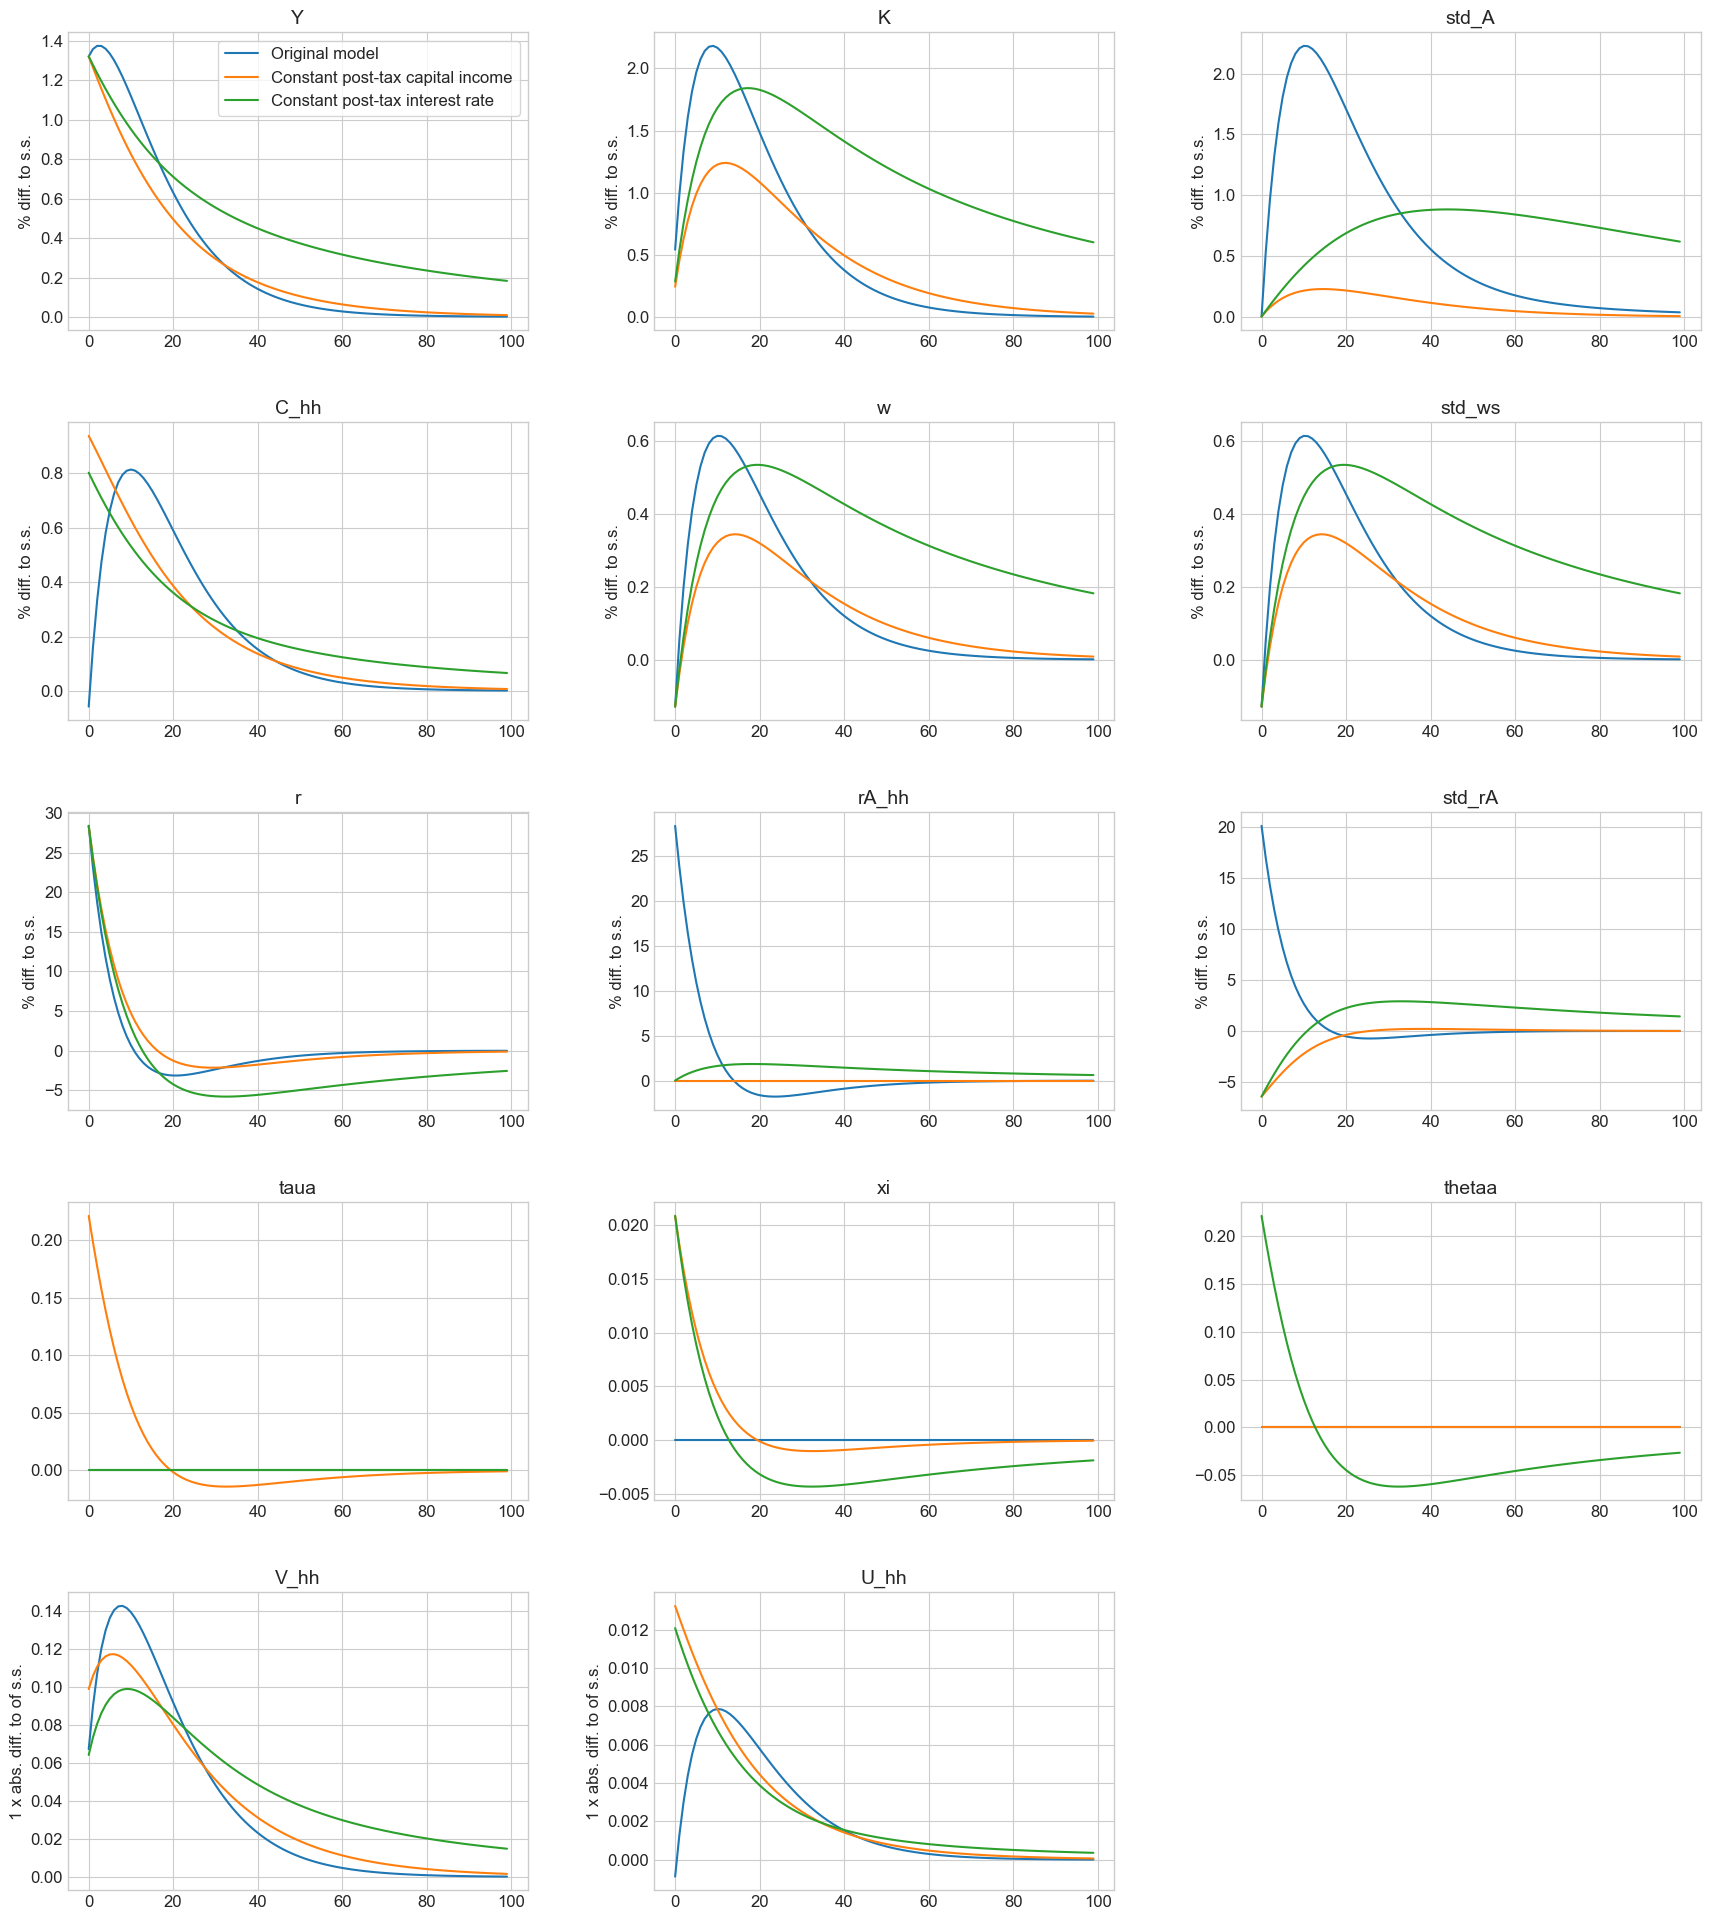

In [56]:
paths = ['Y','K','std_A','C_hh','w','std_ws','r','rA_hh','std_rA','taua','xi','thetaa','V_hh','U_hh']
#abs_diff = ['r','rK']
abs_diff= ['V_hh','U_hh']
lvl_value = ['clearing_A','taua','thetaa','xi']
facs = {'r':100,'rK':100}
model_theta.compare_IRFs([model,model_f,model_theta],['Original model','Constant post-tax capital income','Constant post-tax interest rate'],
                paths,abs_diff=abs_diff,facs=facs,lvl_value=lvl_value,ncols=3,T_max=100,
                do_targets=False,filename=outfolder+r'\IRF_f.png')
                

### shocks ###


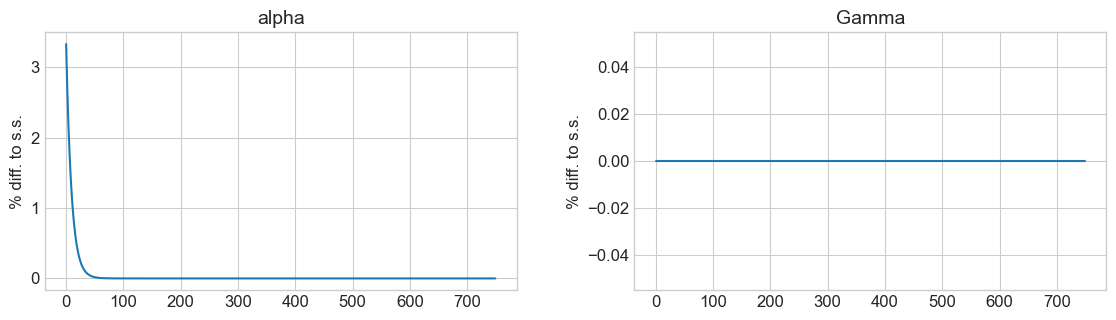


### varnames ###


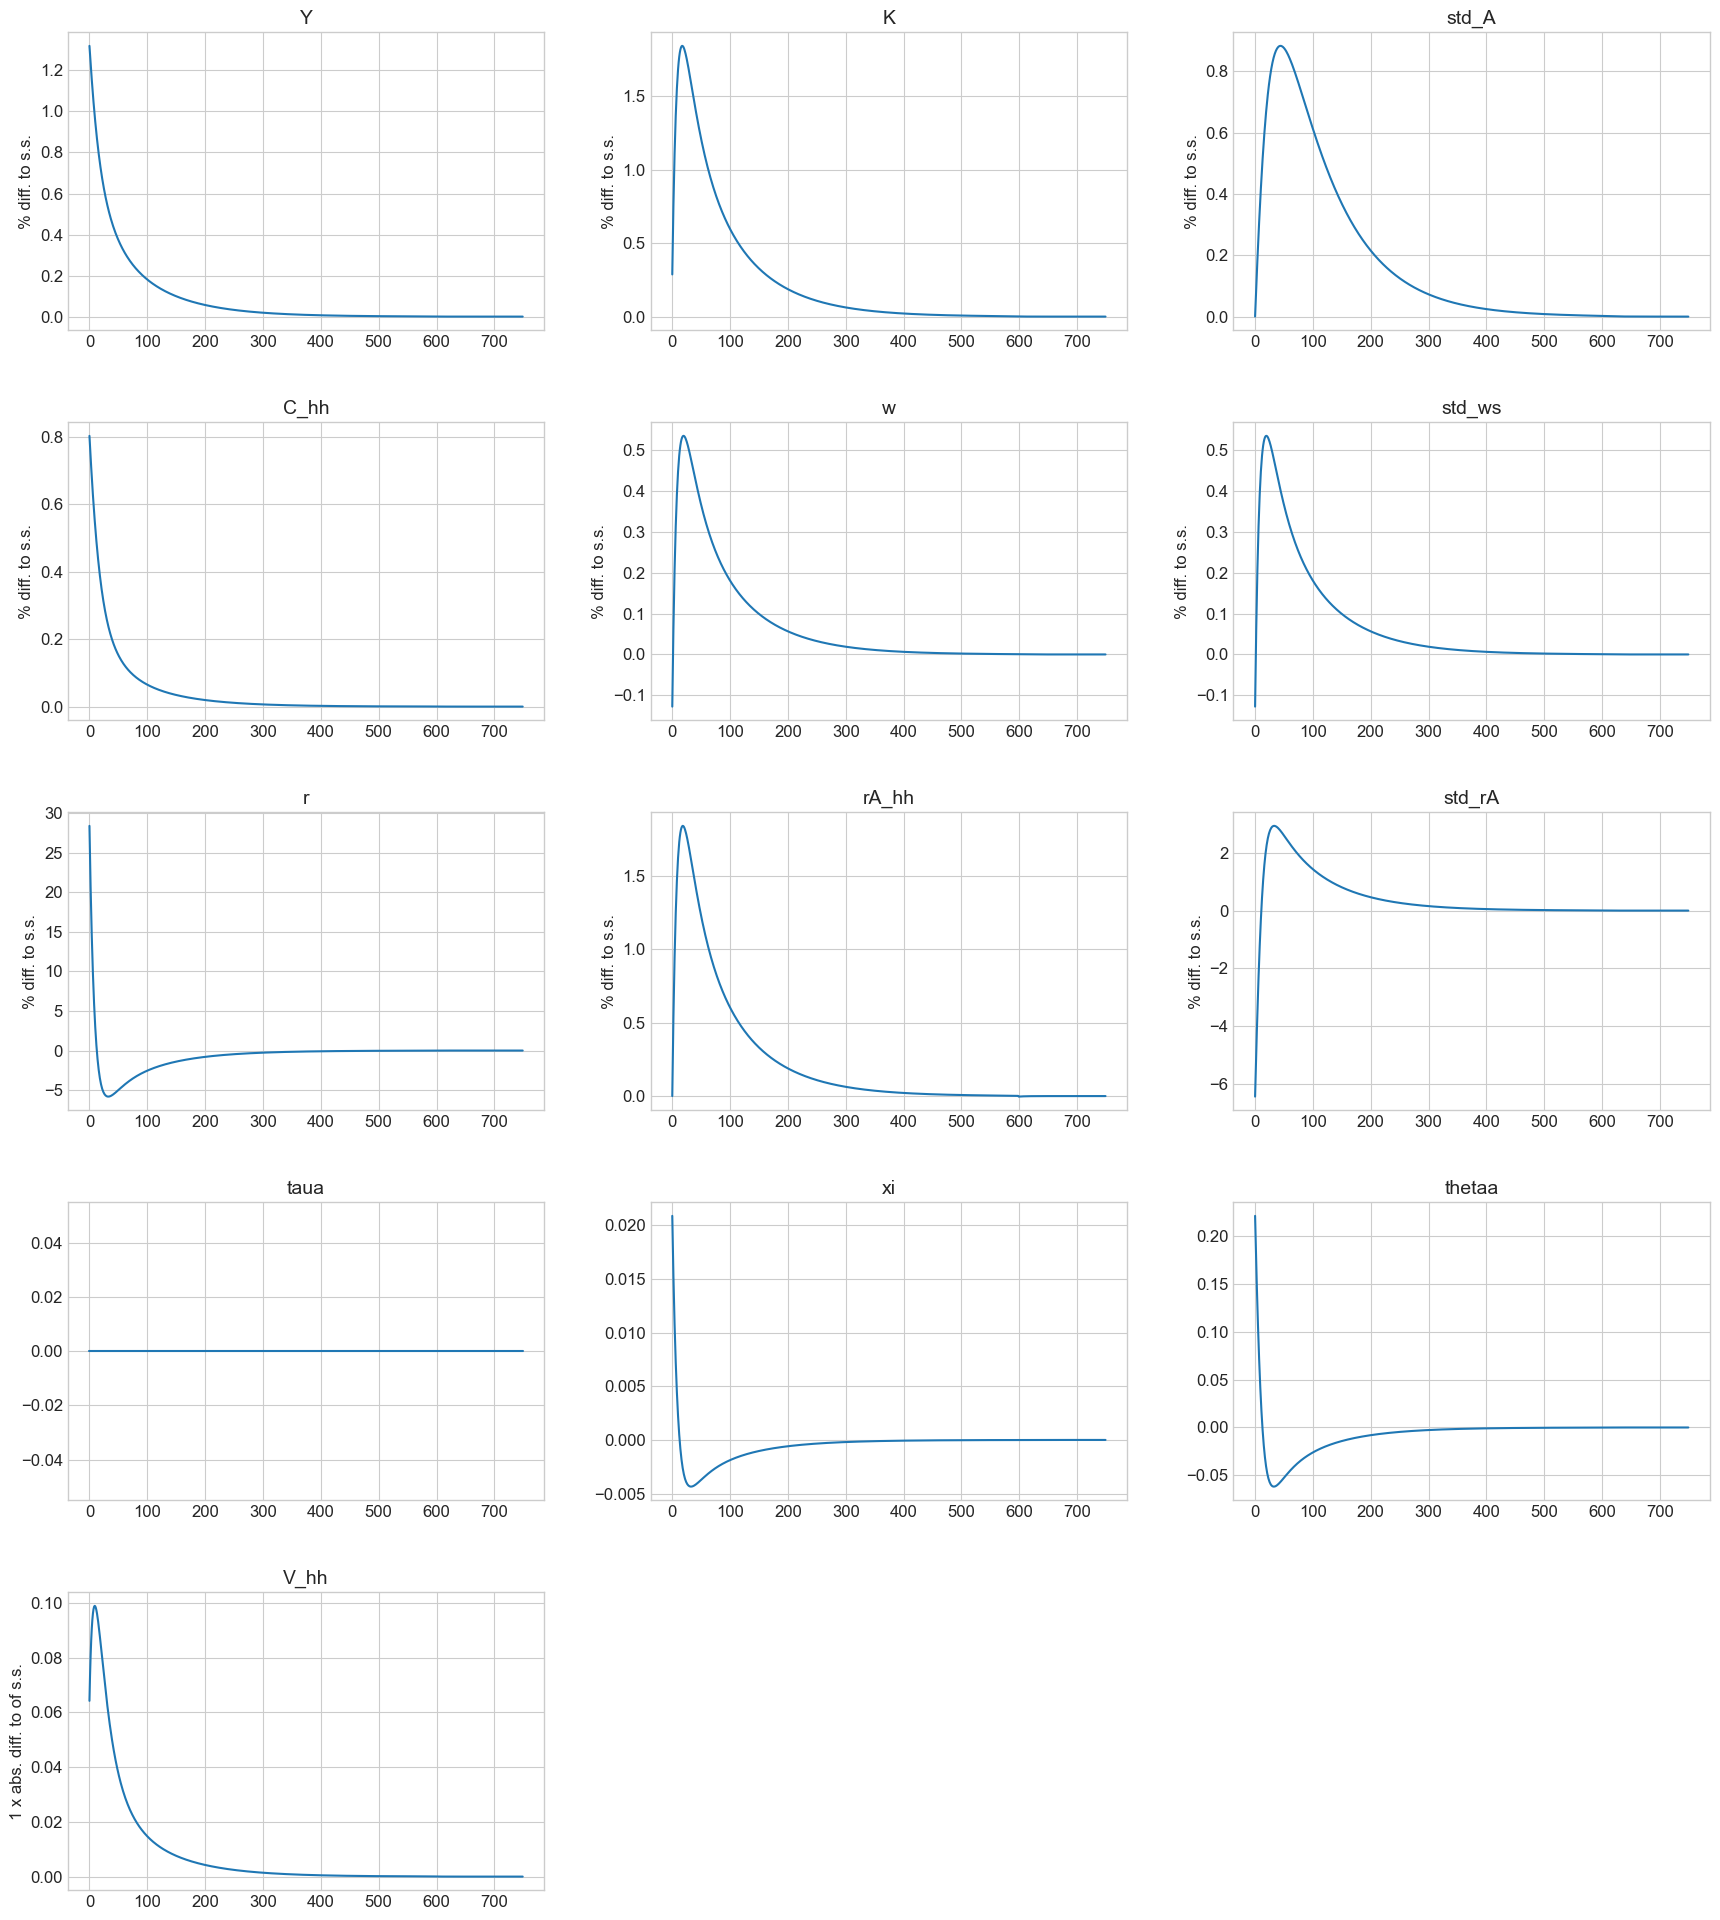


### tagets ###


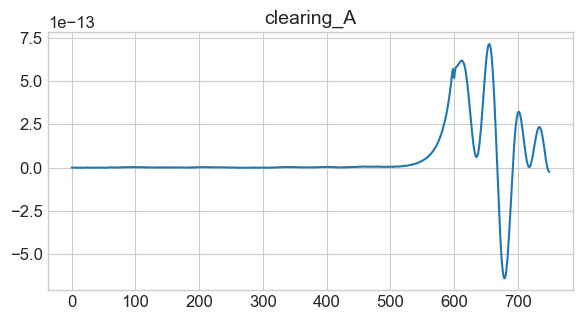

In [47]:
model_theta.show_IRFs(
                paths,abs_diff=abs_diff,facs=facs,lvl_value=lvl_value,ncols=3,T_max=750,
                )